# TurboAz Verilənlərinin Analizi - Müxtəlif Klassifikasiya Modelləri



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Verilənlərin yüklənməsi və hazırlanması

In [15]:
df = pd.read_csv('c:/Users/salim/Desktop/Data Science/Mentor/turbo_az.csv')
df.head(3)

,Avtosalon,Qiymet,Valyuta,Şəhər,Marka,Model,Buraxılış ili,Ban növü,Rəng,Mühərrik,...,Yeni,Vəziyyəti,Yeniləndi,Baxışların sayı,Extra,Etrafli,Sahiblər,Hansı bazar üçün yığılıb,Yerlərin sayı,Qəzalı
0,0,13500,AZN,Bakı,Opel,Vectra,2000,Hetçbek,Göy,1.6 L/101 a.g./Benzin,...,Xeyr,"Vuruğu yoxdur, rənglənib",28.05.2023,267,"Yüngül lehimli disklər, ABS, Kondisioner, Dəri...",Salam Barter mümkündür. 1.6 sadə mator mexanik...,2,Avropa,5,NaN
1,1,23500,USD,Bakı,Toyota,Corolla,2023,Sedan,Mavi,1.8 L/178 a.g./Hibrid,...,Bəli,"Vuruğu yoxdur, rənglənməyib",28.05.2023,12410,"Yüngül lehimli disklər, ABS, Yağış sensoru, Mə...",TOYOTA CAROLLA 2023 ALIŞ. 2 İL 80.000 KM ZƏMAN...,1,Rəsmi diler,5,NaN
2,0,33200,AZN,Bakı,Hyundai,Santa Fe,2013,Offroader / SUV,Qara,2.0 L/184 a.g./Dizel,...,Xeyr,"Vuruğu yoxdur, rənglənməyib",28.05.2023,148,"Yüngül lehimli disklər, ABS, Lyuk, Yağış senso...",Yeni gelib bakida surlmuyb qiymet mawin yanind...,1,Avropa,7,NaN


In [17]:
df_clean = df.copy()

# Qiymətləri AZN-ə çevirək
df_clean['qiymet_azn'] = df_clean['Qiymet']
# USD qiymətləri AZN-ə çevirək (1 USD = 1.7 AZN)
mask_usd = df_clean['Valyuta'] == 'USD'
df_clean.loc[mask_usd, 'qiymet_azn'] = df_clean.loc[mask_usd, 'Qiymet'] * 1.7
# EUR qiymətləri AZN-ə çevirək (1 EUR = 1.85 AZN)
mask_eur = df_clean['Valyuta'] == 'EUR'
df_clean.loc[mask_eur, 'qiymet_azn'] = df_clean.loc[mask_eur, 'Qiymet'] * 1.85

# Sütun adlarını kiçik hərflərə çevirək
df_clean.columns = [col.lower() for col in df_clean.columns]

# Avtomobil yaşını hesablayaq
current_year = 2025
df_clean['avtomobil_yasi'] = current_year - df_clean['buraxılış ili']

# Mühərrik həcmini ədədi dəyərə çevirək
df_clean['muherrik_hecmi'] = df_clean['mühərrik'].str.extract(r'(\d+\.?\d*)').astype(float)

# At gücünü çıxaraq
df_clean['at_gucu'] = df_clean['mühərrik'].str.extract(r'(\d+)\s*a\.g').fillna(0).astype(int)

# Yürüşü ədədi dəyərə çevirək (km)
df_clean['yurus_km'] = df_clean['yürüş'].str.extract(r'(\d+)').astype(float)

# Kateqorik dəyişənləri one-hot encoding ilə kodlaşdıraq
cat_cols = ['şəhər', 'ban növü', 'rəng', 'sürətlər qutusu', 'ötürücü', 'yeni']
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

# Lazımsız sütunları silək
cols_to_drop = ['avtosalon', 'qiymet', 'valyuta', 'marka', 'model', 'mühərrik', 'yürüş', 
                'vəziyyəti', 'yeniləndi', 'baxışların sayı', 'extra', 'etrafli', 
                'sahiblər', 'hansı bazar üçün yığılıb', 'yerlərin sayı', 'qəzalı']
df_encoded = df_encoded.drop(columns=cols_to_drop, errors='ignore')

# NaN dəyərləri olan sətirləri silək
df_encoded = df_encoded.dropna()

# Outlier-ləri təmizləyək (qiymət üçün)
Q1 = df_encoded['qiymet_azn'].quantile(0.01)
Q3 = df_encoded['qiymet_azn'].quantile(0.99)
df_encoded = df_encoded[(df_encoded['qiymet_azn'] >= Q1) & (df_encoded['qiymet_azn'] <= Q3)]

print(f"Təmizlənmiş verilənlərin ölçüsü: {df_encoded.shape}")
df_encoded.head()

Təmizlənmiş verilənlərin ölçüsü: (9808, 106)


C:\Users\salim\AppData\Local\Temp\ipykernel_9564\3366724798.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 39950.  61200.  45050. ...  51000.  38930. 166600.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[mask_usd, 'qiymet_azn'] = df_clean.loc[mask_usd, 'Qiymet'] * 1.7


,buraxılış ili,qiymet_azn,avtomobil_yasi,muherrik_hecmi,at_gucu,yurus_km,şəhər_Ağcabədi,şəhər_Ağdam,şəhər_Ağdaş,şəhər_Ağstafa,...,rəng_Tünd qırmızı,rəng_Yaş Asfalt,rəng_Yaşıl,rəng_Çəhrayı,sürətlər qutusu_Mexaniki,sürətlər qutusu_Robotlaşdırılmış,sürətlər qutusu_Variator,ötürücü_Tam,ötürücü_Ön,yeni_Xeyr
0,2000,13500.0,25,1.6,101,370.0,False,False,False,False,...,False,False,False,False,True,False,False,False,True,True
1,2023,39950.0,2,1.8,178,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2013,33200.0,12,2.0,184,168.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3,2015,17000.0,10,1.5,181,120.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
4,2022,61200.0,3,2.0,173,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## Qiymət kateqoriyalarının yaradılması

Qiymət kateqoriyalarının paylanması:
qiymet_kateqoriyasi
h    4011
g    3361
l    2436
Name: count, dtype: int64

Qiymət kateqoriyalarının faiz nisbəti:
qiymet_kateqoriyasi
h    40.895188
g    34.267945
l    24.836868
Name: proportion, dtype: float64


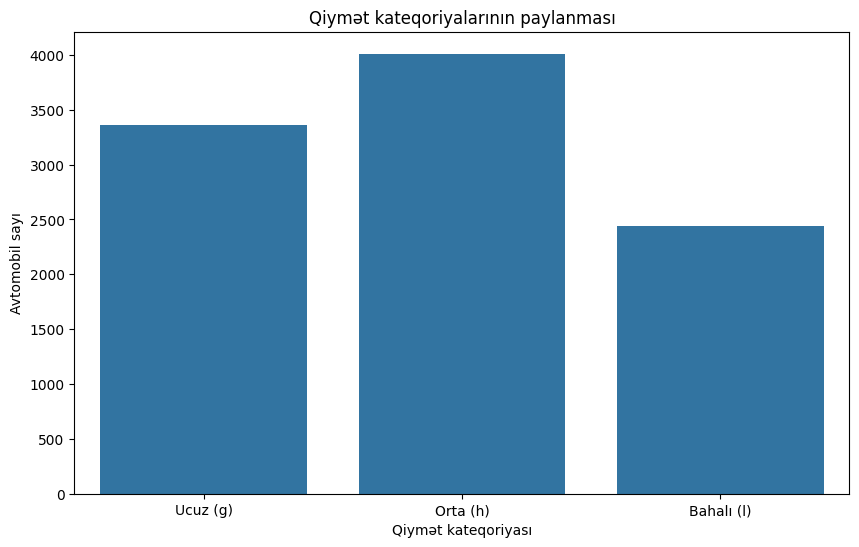

In [4]:
def qiymet_kateqoriyasi(qiymet):
    if qiymet < 15000:  # 15,000 AZN-dən aşağı - ucuz
        return 'g'  # g = ucuz (green)
    elif qiymet < 40000:  # 15,000 - 40,000 AZN - orta
        return 'h'  # h = orta (high)
    else:  # 40,000 AZN-dən yuxarı - bahalı
        return 'l'  # l = bahalı (luxury)

df_encoded['qiymet_kateqoriyasi'] = df_encoded['qiymet_azn'].apply(qiymet_kateqoriyasi)

# Kateqoriyaların paylanmasına baxaq
print("Qiymət kateqoriyalarının paylanması:")
print(df_encoded['qiymet_kateqoriyasi'].value_counts())
print("\nQiymət kateqoriyalarının faiz nisbəti:")
print(df_encoded['qiymet_kateqoriyasi'].value_counts(normalize=True) * 100)

plt.figure(figsize=(10, 6))
sns.countplot(x='qiymet_kateqoriyasi', data=df_encoded)
plt.title('Qiymət kateqoriyalarının paylanması')
plt.xlabel('Qiymət kateqoriyası')
plt.ylabel('Avtomobil sayı')
plt.xticks([0, 1, 2], ['Ucuz (g)', 'Orta (h)', 'Bahalı (l)'])
plt.show()

## Verilənlərin hazırlanması

In [5]:
X = df_encoded.drop(['qiymet_azn', 'qiymet_kateqoriyasi'], axis=1)
y = df_encoded['qiymet_kateqoriyasi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Təlim verilənlərinin ölçüsü: {X_train.shape}")
print(f"Test verilənlərinin ölçüsü: {X_test.shape}")

Təlim verilənlərinin ölçüsü: (7846, 105)
Test verilənlərinin ölçüsü: (1962, 105)


## Model qiymətləndirmə funksiyası

In [18]:
def evaluate_classification_model(model, X_train, X_test, y_train, y_test, model_name, use_scaled=False):
    print(f"\n{model_name} modeli təlim edilir...")
    
    if use_scaled:
        X_train_data = X_train_scaled
        X_test_data = X_test_scaled
    else:
        X_train_data = X_train
        X_test_data = X_test
    
    model.fit(X_train_data, y_train)
    
    y_pred = model.predict(X_test_data)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Doğruluq: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y.unique()), 
                yticklabels=sorted(y.unique()))
    plt.title(f'{model_name}: Confusion Matrix')
    plt.xlabel('Proqnozlaşdırılmış')
    plt.ylabel('Faktiki')
    plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'y_pred': y_pred
    }

## 1. Logistic Regression


Logistic Regression modeli təlim edilir...
Doğruluq: 0.8226

Classification Report:
              precision    recall  f1-score   support

           g       0.87      0.83      0.85       678
           h       0.78      0.79      0.79       795
           l       0.84      0.86      0.85       489

    accuracy                           0.82      1962
   macro avg       0.83      0.83      0.83      1962
weighted avg       0.82      0.82      0.82      1962



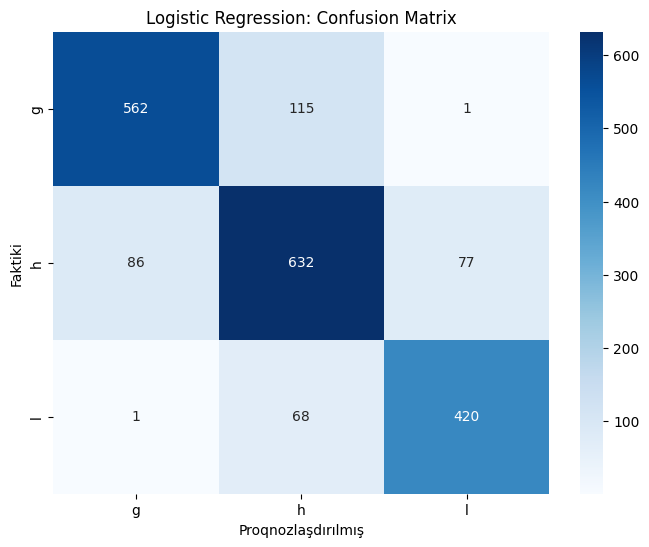

In [7]:
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_results = evaluate_classification_model(lr_clf, X_train, X_test, y_train, y_test, "Logistic Regression", use_scaled=True)

## 2. K-Nearest Neighbors (KNN)


K-Nearest Neighbors modeli təlim edilir...


C:\Users\salim\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\salim\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\salim\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\salim\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in __ini

Doğruluq: 0.7880

Classification Report:
              precision    recall  f1-score   support

           g       0.80      0.82      0.81       678
           h       0.74      0.75      0.75       795
           l       0.85      0.80      0.83       489

    accuracy                           0.79      1962
   macro avg       0.80      0.79      0.79      1962
weighted avg       0.79      0.79      0.79      1962



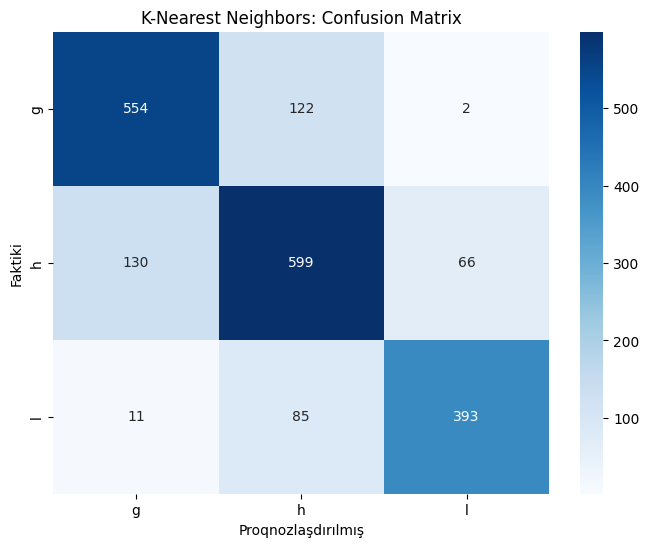

In [8]:
knn_clf = KNeighborsClassifier(n_neighbors=13, n_jobs=1)  # n_jobs=1 xəbərdarlığı aradan qaldırır
knn_results = evaluate_classification_model(knn_clf, X_train, X_test, y_train, y_test, "K-Nearest Neighbors", use_scaled=True)

## 3. Decision Tree


Decision Tree modeli təlim edilir...
Doğruluq: 0.8486

Classification Report:
              precision    recall  f1-score   support

           g       0.86      0.86      0.86       678
           h       0.82      0.81      0.81       795
           l       0.88      0.89      0.88       489

    accuracy                           0.85      1962
   macro avg       0.85      0.85      0.85      1962
weighted avg       0.85      0.85      0.85      1962



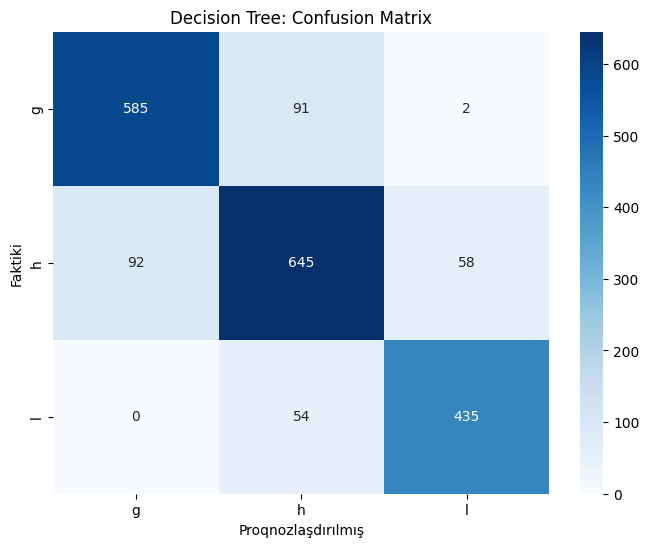

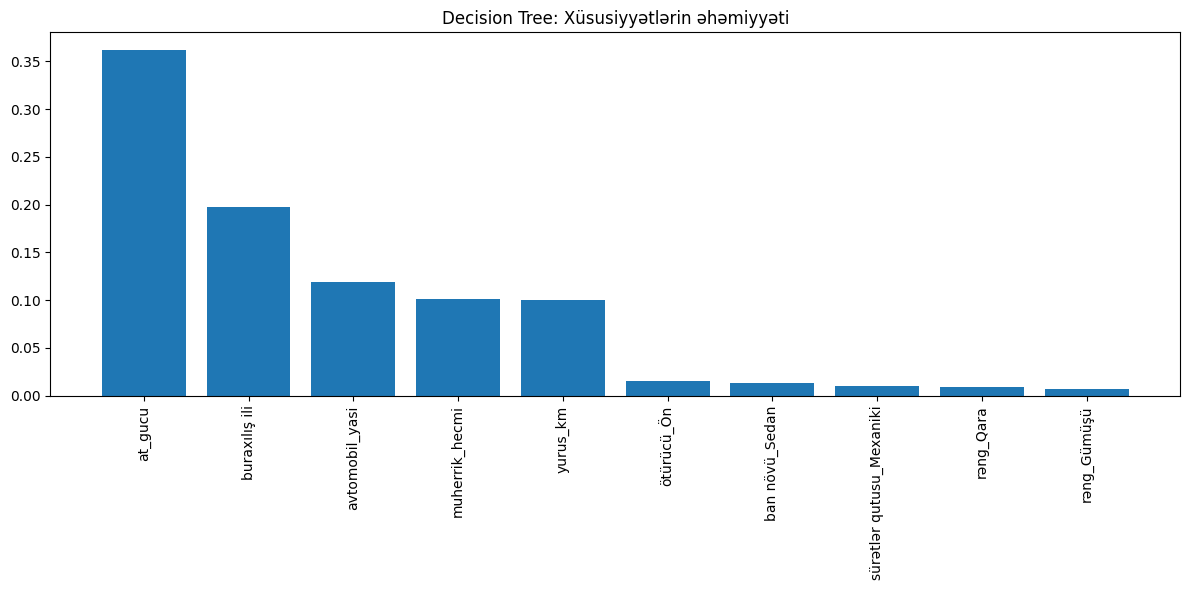

In [9]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_results = evaluate_classification_model(dt_clf, X_train, X_test, y_train, y_test, "Decision Tree")

feature_importances = dt_clf.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Decision Tree: Xüsusiyyətlərin əhəmiyyəti')
plt.bar(range(10), feature_importances[indices[:10]], align='center')
plt.xticks(range(10), feature_names[indices[:10]], rotation=90)
plt.tight_layout()
plt.show()

## 4. Random Forest


Random Forest modeli təlim edilir...
Doğruluq: 0.8772

Classification Report:
              precision    recall  f1-score   support

           g       0.89      0.91      0.90       678
           h       0.86      0.84      0.85       795
           l       0.89      0.90      0.90       489

    accuracy                           0.88      1962
   macro avg       0.88      0.88      0.88      1962
weighted avg       0.88      0.88      0.88      1962



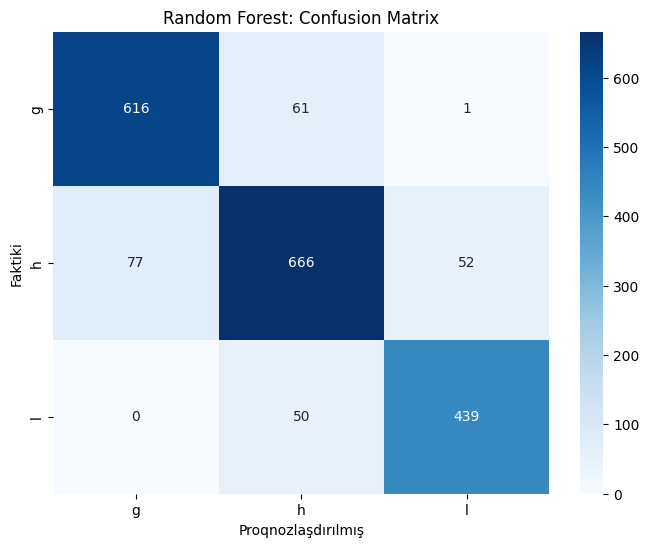

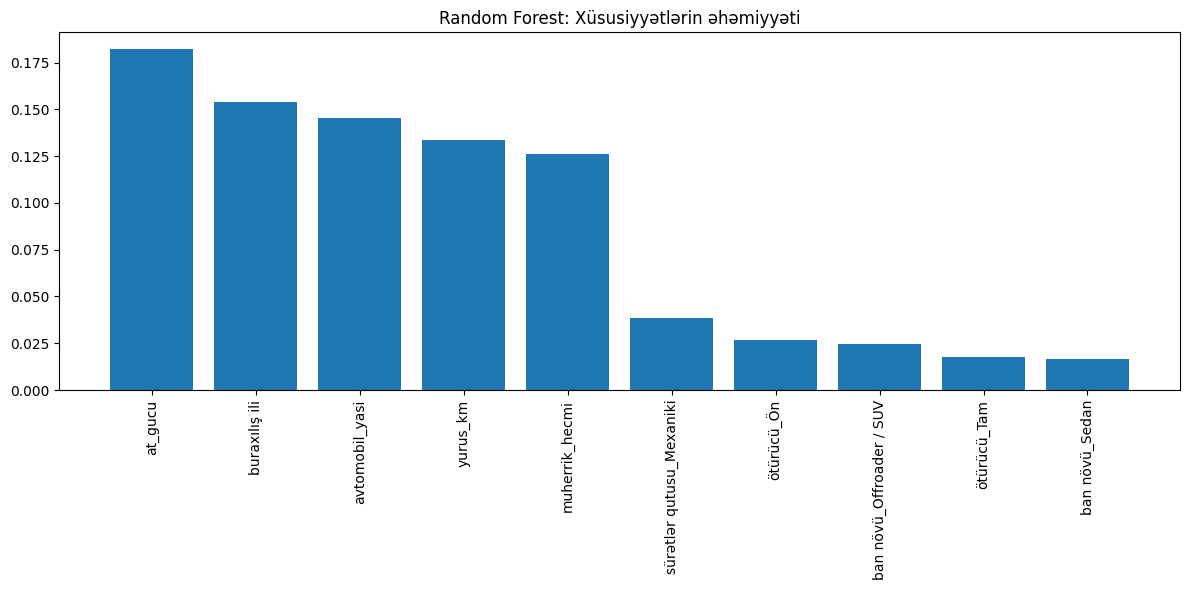

In [10]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
rf_results = evaluate_classification_model(rf_clf, X_train, X_test, y_train, y_test, "Random Forest")

feature_importances = rf_clf.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Random Forest: Xüsusiyyətlərin əhəmiyyəti')
plt.bar(range(10), feature_importances[indices[:10]], align='center')
plt.xticks(range(10), feature_names[indices[:10]], rotation=90)
plt.tight_layout()
plt.show()

## 5. Support Vector Machine (SVM)


Support Vector Machine modeli təlim edilir...
Doğruluq: 0.8150

Classification Report:
              precision    recall  f1-score   support

           g       0.82      0.87      0.84       678
           h       0.79      0.76      0.77       795
           l       0.86      0.83      0.85       489

    accuracy                           0.81      1962
   macro avg       0.82      0.82      0.82      1962
weighted avg       0.82      0.81      0.81      1962



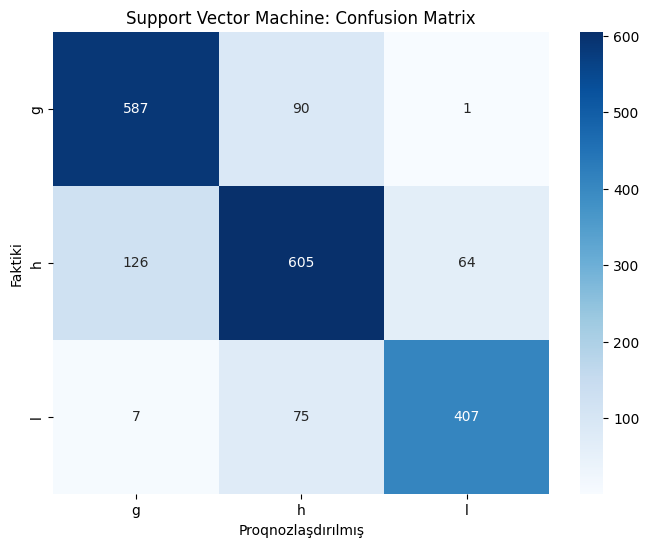

In [11]:
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_results = evaluate_classification_model(svm_clf, X_train, X_test, y_train, y_test, "Support Vector Machine", use_scaled=True)

## 6. Gradient Boosting


Gradient Boosting modeli təlim edilir...
Doğruluq: 0.8802

Classification Report:
              precision    recall  f1-score   support

           g       0.89      0.91      0.90       678
           h       0.86      0.84      0.85       795
           l       0.89      0.91      0.90       489

    accuracy                           0.88      1962
   macro avg       0.88      0.88      0.88      1962
weighted avg       0.88      0.88      0.88      1962



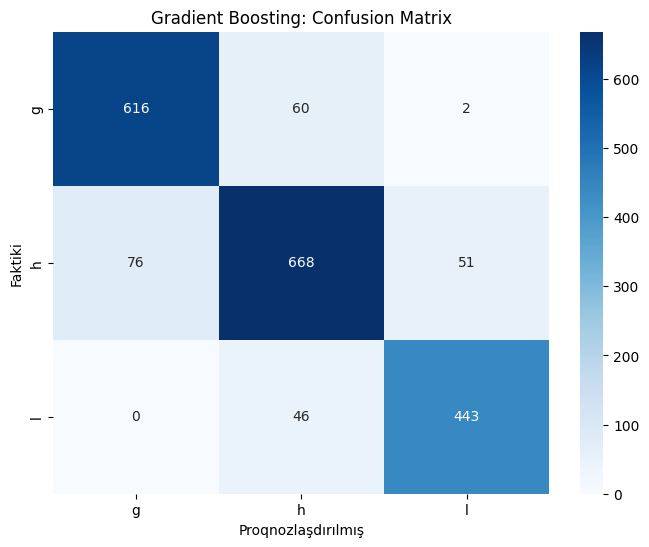

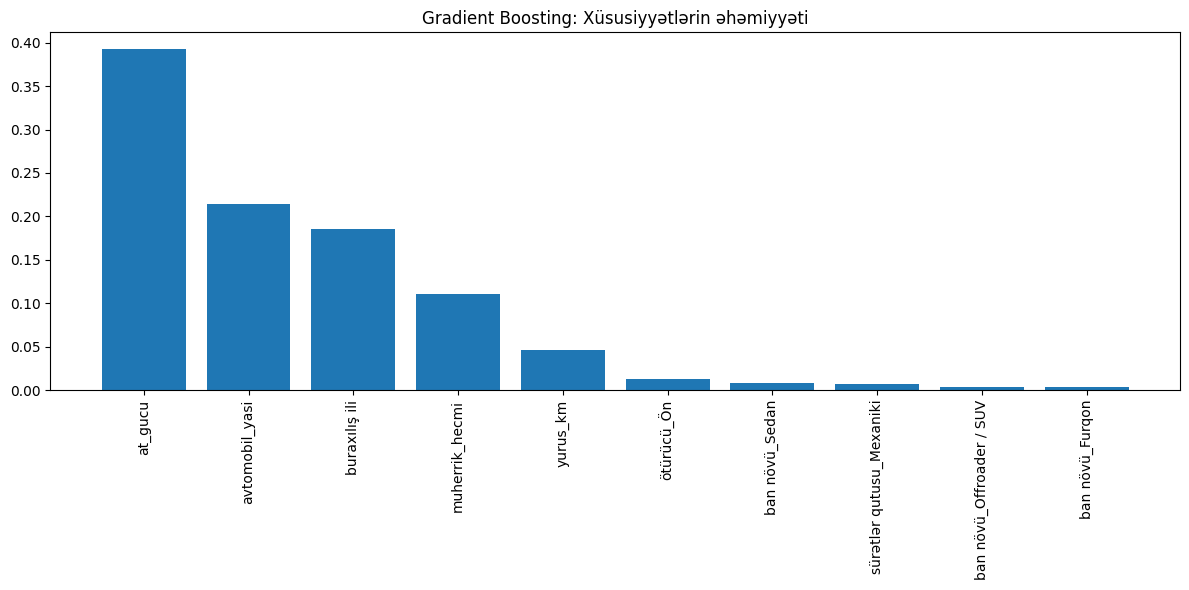

In [12]:
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_results = evaluate_classification_model(gb_clf, X_train, X_test, y_train, y_test, "Gradient Boosting")

feature_importances = gb_clf.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Gradient Boosting: Xüsusiyyətlərin əhəmiyyəti')
plt.bar(range(10), feature_importances[indices[:10]], align='center')
plt.xticks(range(10), feature_names[indices[:10]], rotation=90)
plt.tight_layout()
plt.show()

## Modellərin müqayisəsi

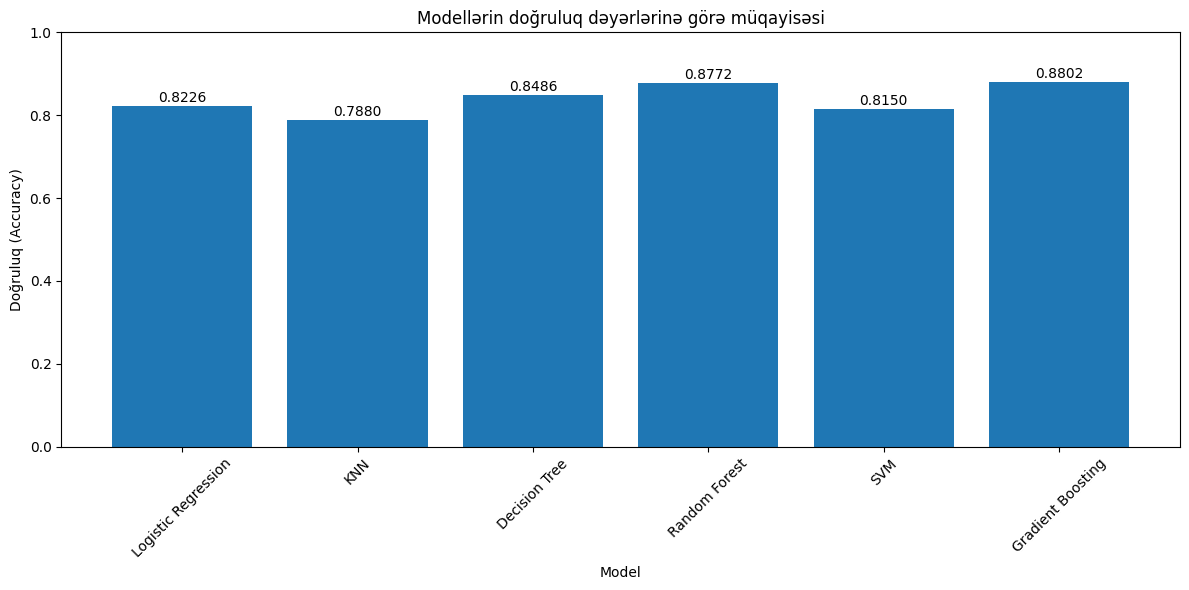


Ən yaxşı model: Gradient Boosting (Doğruluq = 0.8802)


In [13]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM', 'Gradient Boosting']
results = [lr_results, knn_results, dt_results, rf_results, svm_results, gb_results]
accuracies = [result['accuracy'] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(models, accuracies)
plt.title('Modellərin doğruluq dəyərlərinə görə müqayisəsi')
plt.xlabel('Model')
plt.ylabel('Doğruluq (Accuracy)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

best_model_index = np.argmax(accuracies)
best_model_name = models[best_model_index]
print(f"\nƏn yaxşı model: {best_model_name} (Doğruluq = {accuracies[best_model_index]:.4f})")